In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
import torch
import matplotlib.colors as mcolors
from tqdm import tqdm

# Add parent directory to system path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(os.path.join(parent_dir, 'core'))

# Import from core and utils directory 
from algorithms import OnlineMA, OnlineMAPred, OnlineMC, OnlineMAPredAdaptiveEfficient
from utils import rolling_mean, rolling_vec_norm

In [2]:
# Load the COMPAS dataset (adapted from https://github.com/aangelopoulos/gradient-equilibrium/blob/main/compas/debias.ipynb)
df = pd.read_csv('./raw_data/compas-scores-two-years.csv')
df = df[['compas_screening_date', 'sex', 'race', 'v_decile_score', 'is_recid']]
df = df[df.race.isin(["African-American", "Caucasian", "Hispanic"])]
df.compas_screening_date = pd.to_datetime(df.compas_screening_date)

# drop rows after 2014-04-01 (keep rows on or before this date)
cutoff = pd.Timestamp('2014-04-01')
df = df[df.compas_screening_date <= cutoff]

df_req = df.sort_values(by='compas_screening_date', ignore_index=True)
df_req['p_tilde'] = df_req['v_decile_score'] / 10.0

In [3]:
# Output directory for plots
plots_dir = os.path.join(os.getcwd(), "plots")
os.makedirs(plots_dir, exist_ok=True)

In [ ]:
window = 50
window_plot = 50
eta = 0.05
loss = "squared"

# Build arrays aligned to df_req index (0..T-1)
df_req['row_id'] = np.arange(len(df_req), dtype=int)
num_obs = len(df_req)
X = np.zeros((num_obs, 1), dtype=float) 
Y = df_req['is_recid'].to_numpy(dtype=float)
p_tilde_seq = df_req['p_tilde'].to_numpy(dtype=float)
G_df = pd.get_dummies(df_req['race'].astype('category'), drop_first=False)
G = G_df.to_numpy(dtype=float)
num_groups = G.shape[1]
print("number of groups: ", num_groups)

# Group by date and use the (now) positional indices to slice arrays
by_date = df_req.groupby('compas_screening_date', sort=True)
T = len(by_date)

# Online learner (uses external p̃; β-step skipped internally)
maonly = OnlineMA(d=X.shape[1], m=num_groups, window_size=window, gamma_pred=0.0, loss=loss)
maonly_nonadaptive = OnlineMA(d=X.shape[1], m=num_groups, window_size=window, gamma_pred=0.0, loss=loss, num_time_steps=T, adaptive=False)
mapred = OnlineMAPred(d=X.shape[1], m=num_groups, window_size=window, gamma_pred=0.0, loss=loss)
mapred_nonadaptive = OnlineMAPred(d=X.shape[1], m=num_groups, window_size=window, gamma_pred=0.0, loss=loss, num_time_steps=T, adaptive=False)
mapred_adaptive_efficient = OnlineMAPredAdaptiveEfficient(d=X.shape[1], m=num_groups, window_size=window, gamma_pred=0.0, loss=loss, num_time_steps=T, adaptive=False)
mc = OnlineMC(n=10, r=1000, m=num_groups, num_time_steps=T, window_size=window, adaptive=True)
mc_nonadaptive = OnlineMC(n=10, r=1000, m=num_groups, num_time_steps=T, window_size=window, adaptive=False)

# Track metrics
ptilde_baseline_ma_losses = []
maonly_baseline_ma_losses, maonly_baseline_lpred = [], []
maonly_nonadaptive_ma_losses, maonly_nonadaptive_lpred = [], []
mapred_ma_losses, mapred_l_pred = [], []
mapred_nonadaptive_ma_losses, mapred_nonadaptive_l_pred = [], []
mapred_adaptive_efficient_ma_losses, mapred_adaptive_efficient_l_pred = [], []
mc_ma_losses, mc_l_pred = [], []
mc_nonadaptive_ma_losses, mc_nonadaptive_l_pred = [], []

for date, df_d in tqdm(by_date, total=len(by_date)):
    # Build batch for this date
    idxs = df_d['row_id'].to_numpy()
    x_batch = X[idxs]                                  # (b, d)
    y_batch = Y[idxs].astype(float)                    # (b,)
    g_batch = G[idxs]                                  # (b, m)
    pt_batch = p_tilde_seq[idxs].astype(float)         # (b,)

    # Baseline from p̃: use expected group residual vector over the batch
    vec_ptilde = (g_batch * (y_batch - pt_batch)[:, None]).mean(axis=0)
    vec_ptilde = np.asarray(vec_ptilde, dtype=float).ravel()
    ptilde_baseline_ma_losses.append(np.concatenate([vec_ptilde, -vec_ptilde]))

    # Baseline: MA-only baseline (no prediction error objective)
    metrics = maonly.update(x_batch, y_batch, g_batch, p_tilde=pt_batch)
    maonly_baseline_ma_losses.append(metrics["ma_losses"])
    maonly_baseline_lpred.append(metrics["l_pred"])

    # Baseline: Non-adaptive MA-only (no prediction error objective)
    metrics = maonly_nonadaptive.update(x_batch, y_batch, g_batch, p_tilde=pt_batch)
    maonly_nonadaptive_ma_losses.append(metrics["ma_losses"])
    maonly_nonadaptive_lpred.append(metrics["l_pred"])

    # Baseline: Non-adaptive MA+pred
    metrics = mapred_nonadaptive.update(x_batch, y_batch, g_batch, p_tilde=pt_batch)
    mapred_nonadaptive_ma_losses.append(metrics["ma_losses"])
    mapred_nonadaptive_l_pred.append(metrics["l_pred"])
   
    # Locally adaptive MA+pred with external p̃
    metrics = mapred.update(x_batch, y_batch, g_batch, p_tilde=pt_batch)
    mapred_ma_losses.append(metrics["ma_losses"])
    mapred_l_pred.append(metrics["l_pred"])

    # Model update: Adaptive MA+pred
    metrics = mapred_adaptive_efficient.update(x_batch, y_batch, g_batch, p_tilde=pt_batch)
    mapred_adaptive_efficient_ma_losses.append(metrics["ma_losses"])
    mapred_adaptive_efficient_l_pred.append(metrics["l_pred"])

    # Model update: Non-adaptive MC
    metrics = mc_nonadaptive.update(x_batch, y_batch, g_batch, p_tilde=pt_batch)
    mc_nonadaptive_ma_losses.append(metrics["ma_losses"])
    mc_nonadaptive_l_pred.append(metrics["l_pred"])

    # Model update: Locally adaptive MC
    metrics = mc.update(x_batch, y_batch, g_batch, p_tilde=pt_batch)
    mc_ma_losses.append(metrics["ma_losses"])
    mc_l_pred.append(metrics["l_pred"])


ptilde_baseline_ma_l2 = rolling_vec_norm(ptilde_baseline_ma_losses, window_plot, norm="l2")
ptilde_baseline_ma_linf = rolling_vec_norm(ptilde_baseline_ma_losses, window_plot, norm="l_infty")

maonly_baseline_ma_l2 = rolling_vec_norm(maonly_baseline_ma_losses, window_plot, norm="l2")
maonly_baseline_ma_linf = rolling_vec_norm(maonly_baseline_ma_losses, window_plot, norm="l_infty")
maonly_baseline_lpred = rolling_mean(maonly_baseline_lpred, window_plot)

maonly_nonadaptive_ma_l2 = rolling_vec_norm(maonly_nonadaptive_ma_losses, window_plot, norm="l2")
maonly_nonadaptive_ma_linf = rolling_vec_norm(maonly_nonadaptive_ma_losses, window_plot, norm="l_infty")
maonly_nonadaptive_lpred = rolling_mean(maonly_nonadaptive_lpred, window_plot)

mapred_nonadaptive_ma_l2 = rolling_vec_norm(mapred_nonadaptive_ma_losses, window_plot, norm="l2")
mapred_nonadaptive_ma_linf = rolling_vec_norm(mapred_nonadaptive_ma_losses, window_plot, norm="l_infty")
mapred_nonadaptive_l_pred = rolling_mean(mapred_nonadaptive_l_pred, window_plot)

mapred_ma_l2 = rolling_vec_norm(mapred_ma_losses, window_plot, norm="l2")
mapred_ma_linf = rolling_vec_norm(mapred_ma_losses, window_plot, norm="l_infty")
mapred_lpred = rolling_mean(mapred_l_pred, window_plot)

mapred_adaptive_efficient_ma_l2 = rolling_vec_norm(mapred_adaptive_efficient_ma_losses, window_plot, norm="l2")
mapred_adaptive_efficient_ma_linf = rolling_vec_norm(mapred_adaptive_efficient_ma_losses, window_plot, norm="l_infty")
mapred_adaptive_efficient_l_pred = rolling_mean(mapred_adaptive_efficient_l_pred, window_plot)

mc_nonadaptive_ma_l2 = rolling_vec_norm(mc_nonadaptive_ma_losses, window_plot, norm="l2")
mc_nonadaptive_ma_linf = rolling_vec_norm(mc_nonadaptive_ma_losses, window_plot, norm="l_infty")
mc_nonadaptive_l_pred = rolling_mean(mc_nonadaptive_l_pred, window_plot)

mc_ma_l2 = rolling_vec_norm(mc_ma_losses, window_plot, norm="l2")
mc_ma_linf = rolling_vec_norm(mc_ma_losses, window_plot, norm="l_infty")
mc_lpred = rolling_mean(mc_l_pred, window_plot)


In [7]:
# Plotting 
sns.set_style('whitegrid', {'grid.linestyle': '-', 'grid.alpha': 0.4})
sns.set_context('poster')

color_dict = {
    'adaptive':                  'tab:green',
    'non-adaptive':              'tab:red',
    'ptilde':                    'tab:blue',
    'ma':                        'tab:purple',
    'maonly_na':                 'tab:pink',
    'mapred_na':                 'tab:red',
    'mapred':                    'tab:green',
    'mc_na':                     'tab:orange',
    'mc_adaptive':               'tab:brown',
}

plt.rcParams.update({
    'font.size': 28,
    'axes.titlesize': 28,
    'axes.labelsize': 28,
    'legend.fontsize': 24,
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'figure.autolayout': False, 
})

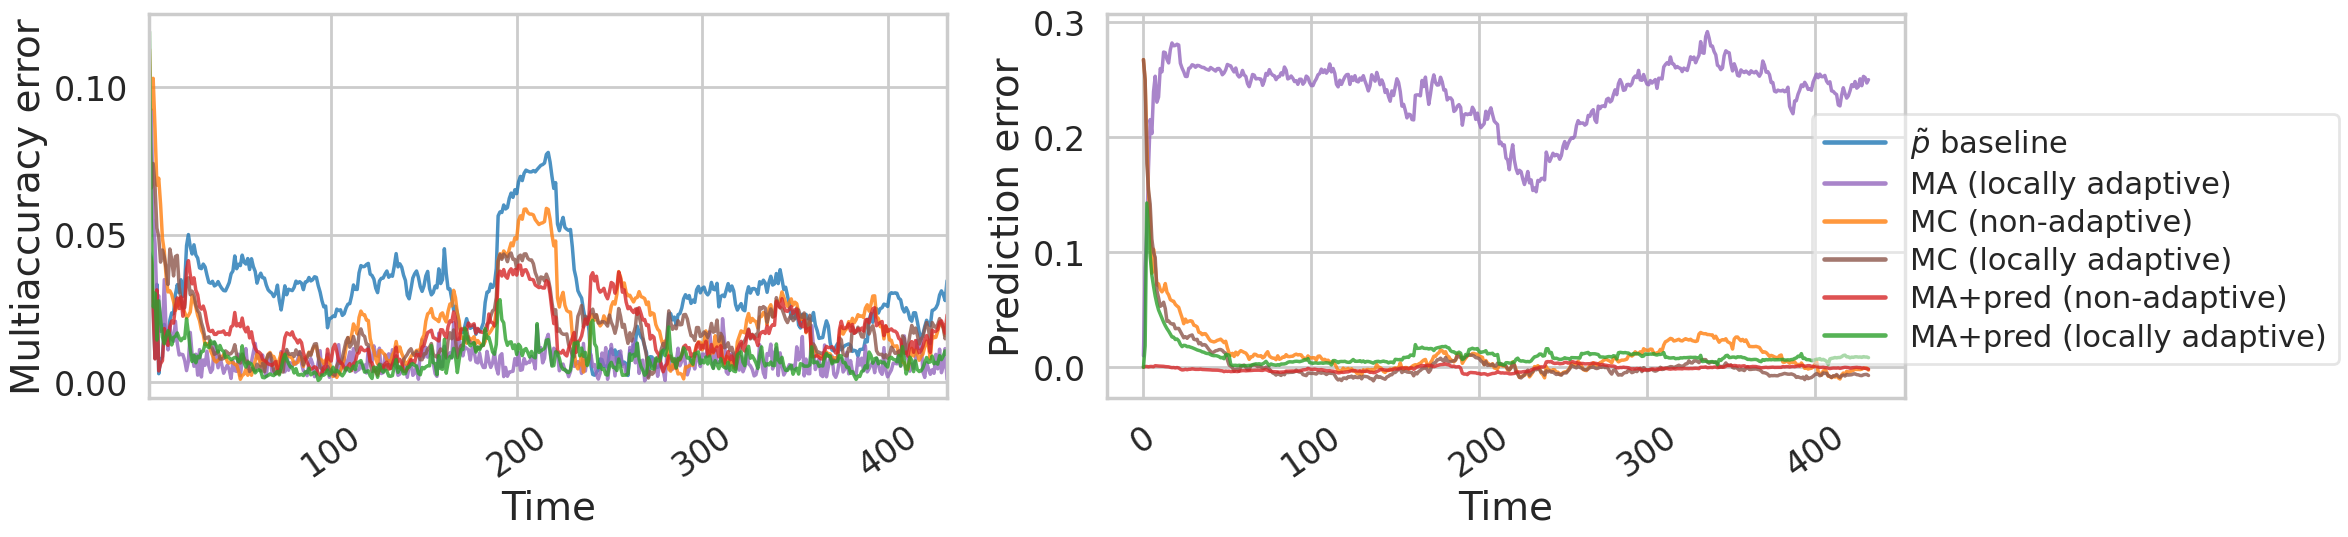

In [18]:
from collections import OrderedDict

series_to_plot = [
    (ptilde_baseline_ma_linf,    r"$\tilde{p}$ baseline",           "ptilde"),
    (maonly_baseline_ma_linf,    r"MA (locally adaptive)",          "ma"),
    (mc_nonadaptive_ma_linf,     r"MC (non-adaptive)",              "mc_na"),
    (mc_ma_linf,                 r"MC (locally adaptive)",          "mc_adaptive"),
    (mapred_nonadaptive_ma_linf, r"MA+pred (non-adaptive)",         "mapred_na"),
    (mapred_ma_linf,             r"MA+pred (locally adaptive)",     "mapred"),
]

pred_series_to_plot = [
    (maonly_baseline_lpred,     r"MA (locally adaptive)",          "ma"),
    (mc_lpred,                  r"MC (non-adaptive)",              "mc_na"),
    (mc_nonadaptive_l_pred,     r"MC (locally adaptive)",          "mc_adaptive"),
    (mapred_nonadaptive_l_pred, r"MA+pred (non-adaptive)",         "mapred_na"),
    (mapred_lpred,              r"MA+pred (locally adaptive)",     "mapred"),
]

fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=False)  
ax_ma, ax_reg = axes

LEFT_SKIP = 2
T_left = max(len(y) for y, _, _ in series_to_plot if y is not None)
x_left = np.arange(T_left)[LEFT_SKIP:]

# Left plot: multiaccuracy error
for y, label, group in series_to_plot:
    if y is None: 
        continue
    yy = np.asarray(y)
    ax_ma.plot(x_left, yy[LEFT_SKIP:], label=label,
               color=color_dict.get(group, "0.3"),
               linewidth=2.5, alpha=0.8)

ax_ma.set_xlim(x_left[0], x_left[-1])
ax_ma.set_xlabel("Time"); ax_ma.set_ylabel("Multiaccuracy error")
ax_ma.tick_params(axis="x", rotation=35); ax_ma.grid(True)

# Right plot: prediction error
for y, label, group in pred_series_to_plot:
    if y is None: 
        continue
    ax_reg.plot(y, label=label, color=color_dict.get(group, "0.3"),
                linewidth=2.5, alpha=0.8)
ax_reg.set_xlabel("Time"); ax_reg.set_ylabel("Prediction error")
ax_reg.tick_params(axis="x", rotation=35); ax_reg.grid(True)

# Legend on the far right
fig.subplots_adjust(right=0.92, wspace=0.28)
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles += h; labels += l
by_label = OrderedDict((l, h) for h, l in zip(handles, labels))

leg = fig.legend(
    by_label.values(), by_label.keys(),
    loc="center left", bbox_to_anchor=(0.925, 0.55),  # tight to the edge
    ncol=1,
    frameon=True, framealpha=0.5,
    fontsize=22,               
    labelspacing=0.3,         # tighter row spacing
)

for line in leg.get_lines():
    line.set_linewidth(3.3)

plt.tight_layout()
fig.savefig(os.path.join(plots_dir, "ma_and_pred_evaluation.pdf"), bbox_inches="tight")
plt.show()

### Varying $\eta$

In [31]:
from algorithms import OnlineMAPredAblation

In [43]:
window = 50
window_plot = 50
eta = 0.05
loss = "squared"

# Build arrays aligned to df_req index (0..T-1)
df_req['row_id'] = np.arange(len(df_req), dtype=int)
num_obs = len(df_req)
X = np.zeros((num_obs, 1), dtype=float) 
Y = df_req['is_recid'].to_numpy(dtype=float)
p_tilde_seq = df_req['p_tilde'].to_numpy(dtype=float)
G_df = pd.get_dummies(df_req['race'].astype('category'), drop_first=False)
G = G_df.to_numpy(dtype=float)
num_groups = G.shape[1]
print("number of groups: ", num_groups)

# Group by date and use the (now) positional indices to slice arrays
by_date = df_req.groupby('compas_screening_date', sort=True)
T = len(by_date)

mapred_constant_eta = OnlineMAPredAblation(d=X.shape[1], m=num_groups, window_size=window, gamma_pred=0.0, loss=loss, num_time_steps=T, adaptive=True, ablation_eta="constant")
mapred_interval_eta = OnlineMAPredAblation(d=X.shape[1], m=num_groups, window_size=window, gamma_pred=0.0, loss=loss, num_time_steps=T, adaptive=True, ablation_eta="interval")
mapred_adaptive_eta = OnlineMAPredAblation(d=X.shape[1], m=num_groups, window_size=window, gamma_pred=0.0, loss=loss, num_time_steps=T, adaptive=True, ablation_eta="adaptive")

mapred_constant_eta_ma_losses, mapred_constant_eta_l_pred = [], []
mapred_interval_eta_ma_losses, mapred_interval_eta_l_pred = [], []
mapred_adaptive_eta_ma_losses, mapred_adaptive_eta_l_pred = [], []

for date, df_d in tqdm(by_date, total=len(by_date)):
    # Build batch for this date
    idxs = df_d['row_id'].to_numpy()
    x_batch = X[idxs]                                  # (b, d)
    y_batch = Y[idxs].astype(float)                    # (b,)
    g_batch = G[idxs]                                  # (b, m)
    pt_batch = p_tilde_seq[idxs].astype(float)         # (b,)

    metrics = mapred_constant_eta.update(x_batch, y_batch, g_batch, p_tilde=pt_batch)
    mapred_constant_eta_ma_losses.append(metrics["ma_losses"])
    mapred_constant_eta_l_pred.append(metrics["l_pred"])

    metrics = mapred_interval_eta.update(x_batch, y_batch, g_batch, p_tilde=pt_batch)
    mapred_interval_eta_ma_losses.append(metrics["ma_losses"])
    mapred_interval_eta_l_pred.append(metrics["l_pred"])

    metrics = mapred_adaptive_eta.update(x_batch, y_batch, g_batch, p_tilde=pt_batch)
    mapred_adaptive_eta_ma_losses.append(metrics["ma_losses"])
    mapred_adaptive_eta_l_pred.append(metrics["l_pred"])

mapred_constant_eta_ma_l2 = rolling_vec_norm(mapred_constant_eta_ma_losses, window_plot, norm="l2")
mapred_constant_eta_ma_linf = rolling_vec_norm(mapred_constant_eta_ma_losses, window_plot, norm="l_infty")
mapred_constant_eta_lpred = rolling_mean(mapred_constant_eta_l_pred, window_plot)

mapred_interval_eta_ma_l2 = rolling_vec_norm(mapred_interval_eta_ma_losses, window_plot, norm="l2")
mapred_interval_eta_ma_linf = rolling_vec_norm(mapred_interval_eta_ma_losses, window_plot, norm="l_infty")
mapred_interval_eta_lpred = rolling_mean(mapred_interval_eta_l_pred, window_plot)

mapred_adaptive_eta_ma_l2 = rolling_vec_norm(mapred_adaptive_eta_ma_losses, window_plot, norm="l2")
mapred_adaptive_eta_ma_linf = rolling_vec_norm(mapred_adaptive_eta_ma_losses, window_plot, norm="l_infty")
mapred_adaptive_eta_lpred = rolling_mean(mapred_adaptive_eta_l_pred, window_plot)


number of groups:  3


100%|██████████| 433/433 [00:23<00:00, 18.21it/s]


In [33]:
window_plot_small = int(50 / 2)
window_plot_large = int(50 * 2)

mapred_constant_eta_ma_linf_small = rolling_vec_norm(mapred_constant_eta_ma_losses, window_plot_small, norm="l_infty")
mapred_constant_eta_ma_linf_large = rolling_vec_norm(mapred_constant_eta_ma_losses, window_plot_large, norm="l_infty")

mapred_interval_eta_ma_linf_small = rolling_vec_norm(mapred_interval_eta_ma_losses, window_plot_small, norm="l_infty")
mapred_interval_eta_ma_linf_large = rolling_vec_norm(mapred_interval_eta_ma_losses, window_plot_large, norm="l_infty")

mapred_adaptive_eta_ma_linf_small = rolling_vec_norm(mapred_adaptive_eta_ma_losses, window_plot_small, norm="l_infty")
mapred_adaptive_eta_ma_linf_large = rolling_vec_norm(mapred_adaptive_eta_ma_losses, window_plot_large, norm="l_infty")



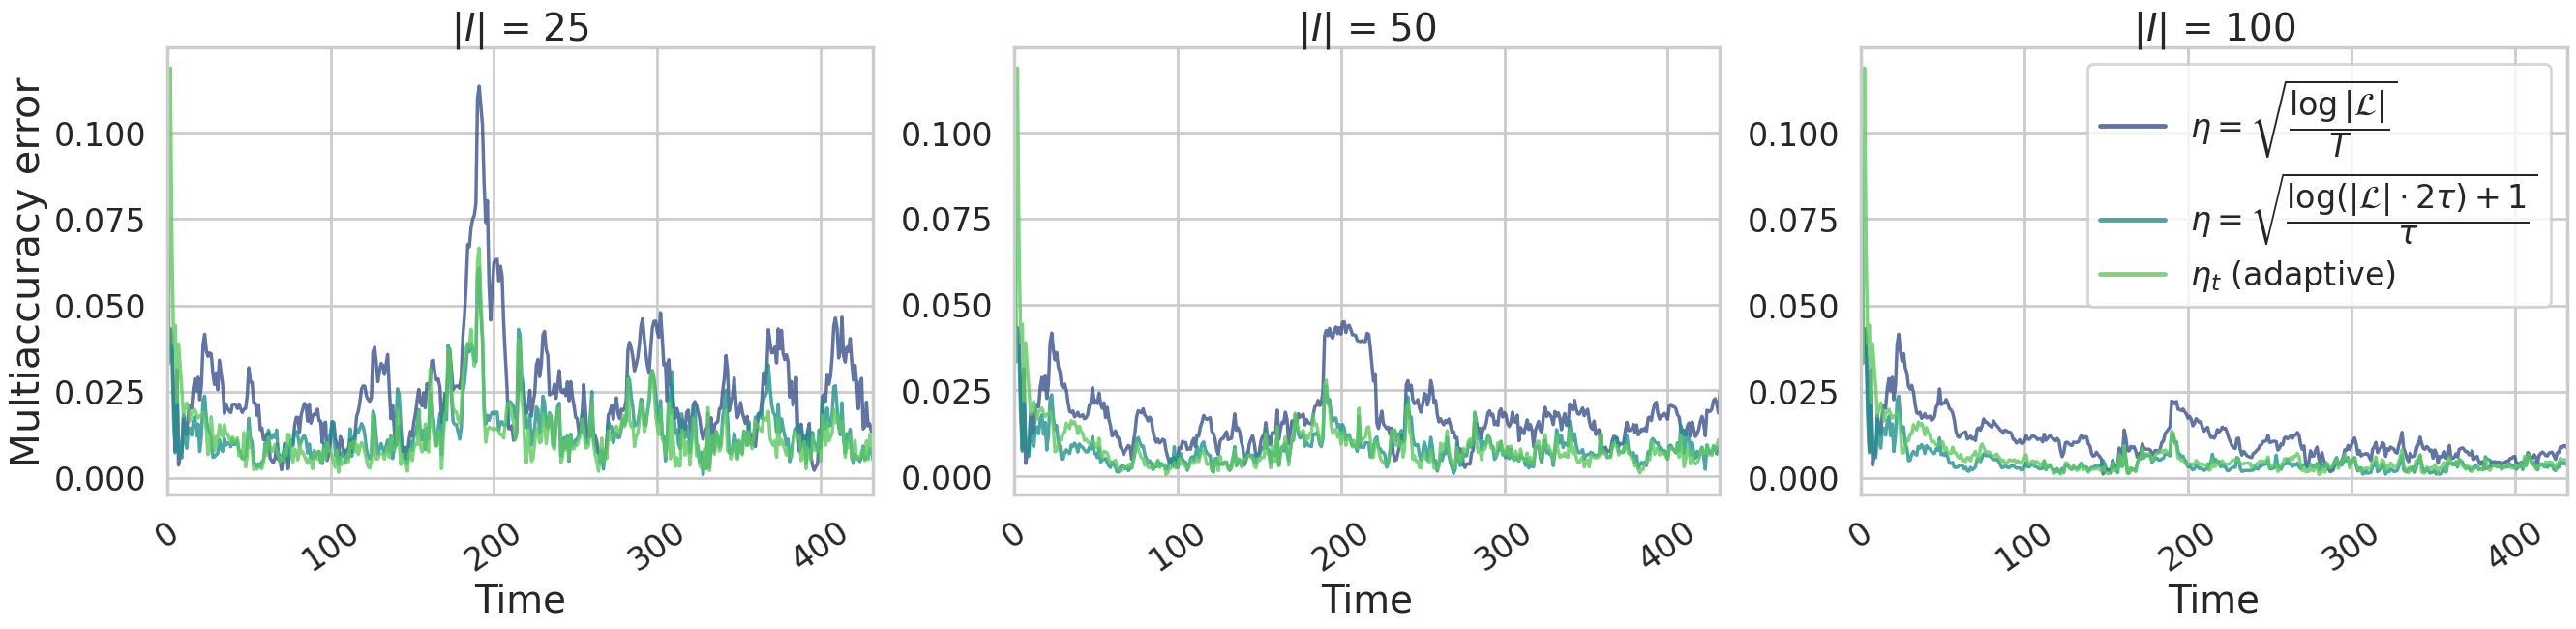

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(32, 6), sharex=False)
ax_small, ax_mid, ax_large = axes

ma_rolling_by_eta = {
    "constant": mapred_constant_eta_ma_linf,
    "interval": mapred_interval_eta_ma_linf,
    "adaptive": mapred_adaptive_eta_ma_linf,
}

ma_rolling_by_eta_small = {
    "constant": mapred_constant_eta_ma_linf_small,
    "interval": mapred_interval_eta_ma_linf_small,
    "adaptive": mapred_adaptive_eta_ma_linf_small,
}

ma_rolling_by_eta_large = {
    "constant": mapred_constant_eta_ma_linf_large,
    "interval": mapred_interval_eta_ma_linf_large,
    "adaptive": mapred_adaptive_eta_ma_linf_large,
}

labels = {
    "constant": r"$\eta = \sqrt{\dfrac{\log{|\mathcal{L}|}}{T}}$",
    "interval": r"$\eta = \sqrt{\dfrac{\log(|\mathcal{L}|\cdot 2\tau) + 1}{\tau}}$",
    "adaptive": r"$\eta_t$ (adaptive)",
}

LEFT_SKIP = 0
T_left = max(len(y) for y in ma_rolling_by_eta.values())
x_left = np.arange(T_left)[LEFT_SKIP:]

# LEFT: |I| = 25 
palette = sns.color_palette("viridis", n_colors=3)
for color, eta in zip(palette, ma_rolling_by_eta_small.keys()):
    yy = np.asarray(ma_rolling_by_eta_small[eta])
    ax_small.plot(x_left, yy[LEFT_SKIP:], label=labels[eta], color=color, linewidth=2.5, alpha=0.8)

ax_small.set_xlim(x_left[0], x_left[-1])
ax_small.set_title(r"$|I|$ = 25")
ax_small.set_xlabel("Time")
ax_small.set_ylabel("Multiaccuracy error", fontsize=30)
ax_small.tick_params(axis="x", rotation=35)
ax_small.grid(True)

# MIDDLE: |I| = 50  
for color, eta in zip(palette, ma_rolling_by_eta.keys()):
    yy = np.asarray(ma_rolling_by_eta[eta])
    ax_mid.plot(x_left, yy[LEFT_SKIP:], label=labels[eta], color=color, linewidth=2.5, alpha=0.8)
ax_mid.set_xlim(x_left[0], x_left[-1])
ax_mid.set_title(r"$|I|$ = 50")
ax_mid.set_xlabel("Time")
ax_mid.tick_params(axis="x", rotation=35)
ax_mid.grid(True)

# RIGHT: |I| = 100 
for color, eta in zip(palette, ma_rolling_by_eta_large.keys ()):
    yy = np.asarray(ma_rolling_by_eta_large[eta])
    ax_large.plot(x_left, yy[LEFT_SKIP:], label=labels[eta], color=color, linewidth=2.5, alpha=0.8)
ax_large.set_xlim(x_left[0], x_left[-1])
ax_large.set_title(r"$|I|$ = 100")
ax_large.set_xlabel("Time")
ax_large.tick_params(axis="x", rotation=35)
ax_large.grid(True)

leg = ax_large.legend(loc="upper right", bbox_to_anchor=(1, 1), ncol=1, fontsize=24, labelspacing=0.35)
for line in leg.get_lines():
    line.set_linewidth(3.5)

plt.savefig(os.path.join(plots_dir, "varying_eta.pdf"), dpi=300, bbox_inches="tight")
plt.show()

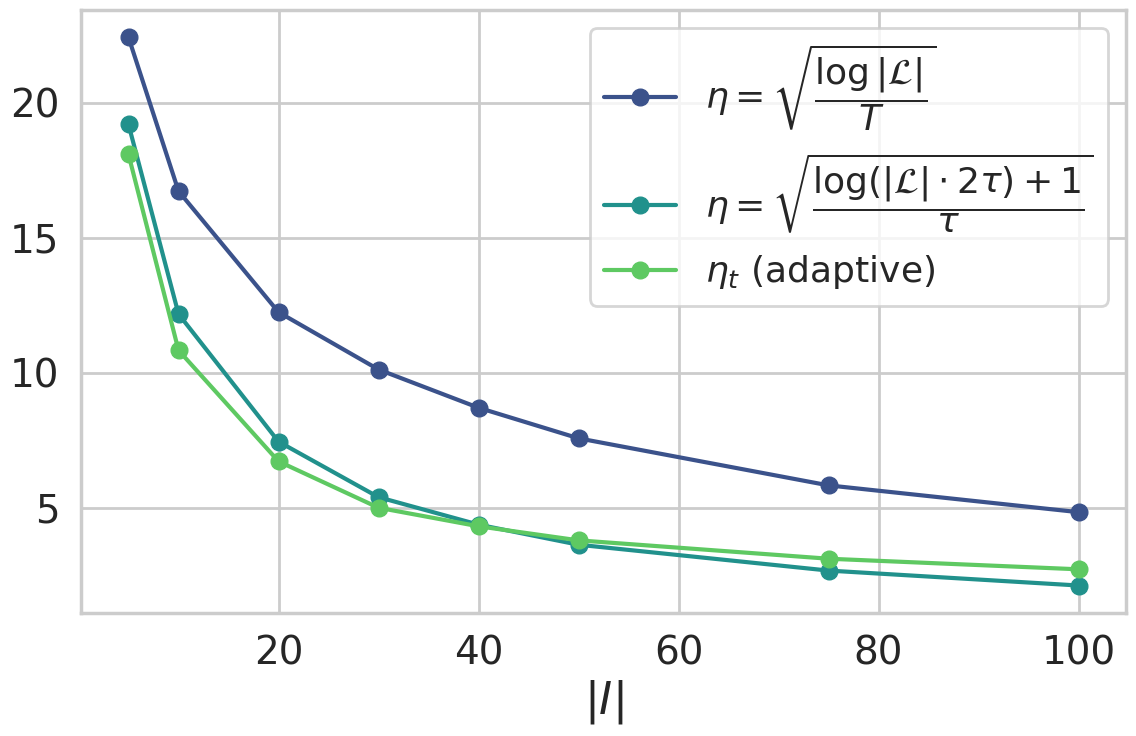

In [11]:
window_grid = [5, 10, 20, 30, 40, 50, 75, 100]
LEFT_SKIP = 0

methods_eta = {
    "constant": mapred_constant_eta_ma_losses,
    "interval": mapred_interval_eta_ma_losses,
    "adaptive": mapred_adaptive_eta_ma_losses,
}
totals_by_eta_method = {name: [] for name in methods_eta.keys()}

for w in window_grid:
    for name, losses_vecs in methods_eta.items():
        # rolling over vectors then norm; use same function as elsewhere
        series = rolling_vec_norm(losses_vecs, w, norm="l_infty")
        totals_by_eta_method[name].append(float(np.sum(np.asarray(series))))

palette = sns.color_palette("viridis", n_colors=len(methods_eta))
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
for color, eta in zip(palette, methods_eta.keys()):
    ax.plot(window_grid, totals_by_eta_method[eta], marker="o", color=color, linestyle="-", linewidth=3, label=labels[eta])

ax.set_xlabel(r"$|I|$", fontsize=32)
# ax.set_ylabel("Total MA error", fontsize=37)
ax.tick_params(axis="x", labelsize=28)
ax.tick_params(axis="y", labelsize=28)
ax.grid(True)
ax.legend(loc="best", fontsize=26)
plt.tight_layout()

fig.savefig(os.path.join(plots_dir, "varying_eta_and_window.pdf"), bbox_inches="tight")
plt.show()


### Varying $\gamma$

In [35]:
eta = 0.05
loss = "squared"

# Build arrays aligned to df_req index (0..T-1)
df_req['row_id'] = np.arange(len(df_req), dtype=int)
num_obs = len(df_req)
X = np.zeros((num_obs, 1), dtype=float) 
Y = df_req['is_recid'].to_numpy(dtype=float)
p_tilde_seq = df_req['p_tilde'].to_numpy(dtype=float)
G_df = pd.get_dummies(df_req['race'].astype('category'), drop_first=False)
G = G_df.to_numpy(dtype=float)
num_groups = G.shape[1]
print("number of groups: ", num_groups)

# Group by date and use the (now) positional indices to slice arrays
by_date = df_req.groupby('compas_screening_date', sort=True)
T = len(by_date)

number of groups:  3


In [36]:
fitting_window = [10, 25, 50, 100, 200]

online_ma_pred_by_fitting_window = {}
for w in fitting_window:
    online_ma_pred_by_fitting_window[w] = OnlineMAPred(d=X.shape[1], m=num_groups, window_size=w, gamma_pred=0.0, loss=loss, num_time_steps=T, adaptive=True)

ma_losses_by_fitting_window = {}
l_pred_by_fitting_window = {}
for w in fitting_window:
    ma_losses_by_fitting_window[w] = []
    l_pred_by_fitting_window[w] = []

for date, df_d in tqdm(by_date, total=len(by_date)):
    idxs = df_d['row_id'].to_numpy()
    x_batch = X[idxs]
    y_batch = Y[idxs].astype(float)
    g_batch = G[idxs]
    pt_batch = p_tilde_seq[idxs].astype(float)
    for w in fitting_window:
        metrics = online_ma_pred_by_fitting_window[w].update(x_batch, y_batch, g_batch, p_tilde=pt_batch)
        ma_losses_by_fitting_window[w].append(metrics["ma_losses"])
        l_pred_by_fitting_window[w].append(metrics["l_pred"])

100%|██████████| 433/433 [00:38<00:00, 11.17it/s]


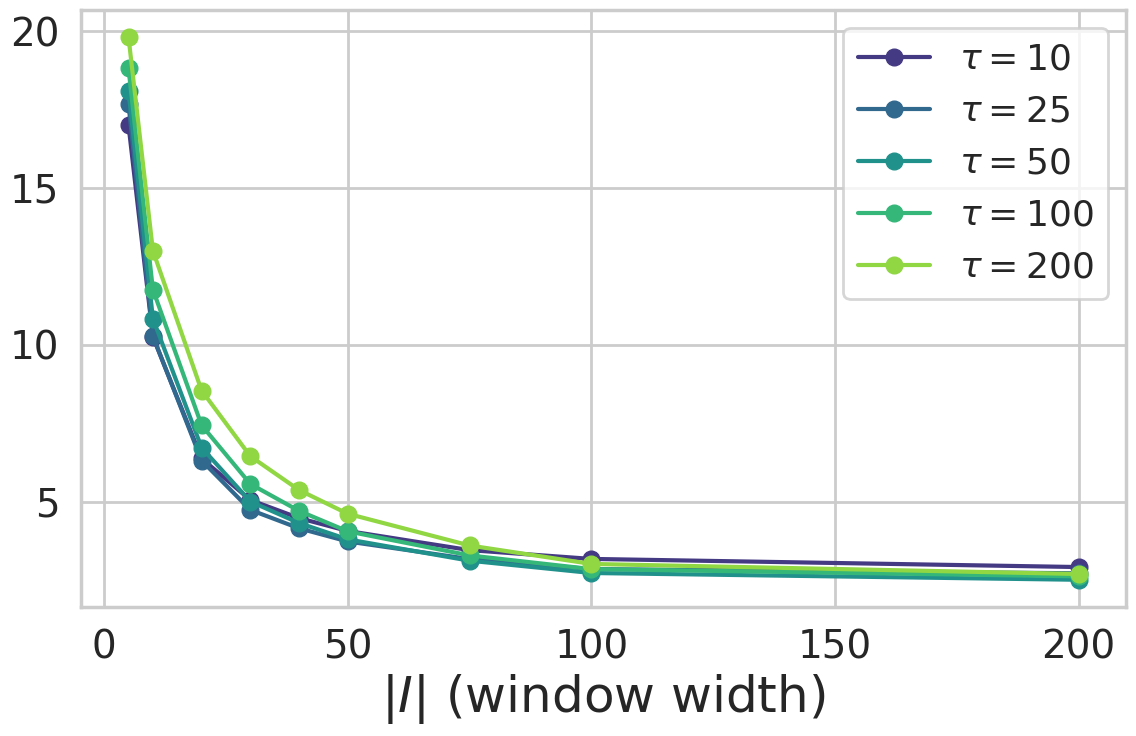

In [42]:
window_grid = [5, 10, 20, 30, 40, 50, 75, 100, 200]
LEFT_SKIP = 0

methods_by_window = {}
for w in fitting_window:
    methods_by_window[w] = ma_losses_by_fitting_window[w]
totals_by_window = {name: [] for name in methods_by_window.keys()}

for wg in window_grid:
    for name, losses_vecs in methods_by_window.items():
        series = rolling_vec_norm(losses_vecs, wg, norm="l_infty")
        totals_by_window[name].append(float(np.sum(np.asarray(series))))

palette = sns.color_palette("viridis", n_colors=len(methods_by_window))
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
for color, w in zip(palette, methods_by_window.keys()):
    ax.plot(window_grid, totals_by_window[w], marker="o", color=color, linestyle="-", linewidth=3, label=fr"$\tau={w}$")

ax.set_xlabel(r"$|I|$ (window width)", fontsize=36)
ax.tick_params(axis="x", labelsize=28)
ax.tick_params(axis="y", labelsize=28)
ax.grid(True)
ax.legend(loc="best", fontsize=26)

plt.tight_layout()
fig.savefig(os.path.join(plots_dir, "varying_gamma.pdf"), bbox_inches="tight")
plt.show()


### Varying number of bins

In [ ]:
by_date = df_req.groupby('compas_screening_date', sort=True)
T = len(by_date)

num_bins = [20, 30, 40, 50]

mc_ma_losses_by_n = {}
for n in num_bins:
    print(f"Running MC with num bins={n}")
    mc = OnlineMC(n=n, r=1000, m=num_groups, n_forecaster=10, num_time_steps=T, seed=42)
    losses_vecs = []
    for date, df_d in tqdm(by_date, total=len(by_date)):
        idxs = df_d['row_id'].to_numpy()
        x_batch = X[idxs]
        y_batch = y[idxs].astype(float)
        g_batch = G[idxs]
        pt_batch = p_tilde_seq[idxs].astype(float)
        metrics = mc.update(x_batch, y_batch, g_batch, p_tilde=pt_batch)
        losses_vecs.append(np.asarray(metrics["ma_losses"], dtype=float))  # (2m,)
    mc_ma_losses_by_n[n] = losses_vecs

mc_rolling_by_n = {n: rolling_vec_norm(V, window_plot, norm="l_infty") for n, V in mc_ma_losses_by_n.items()}

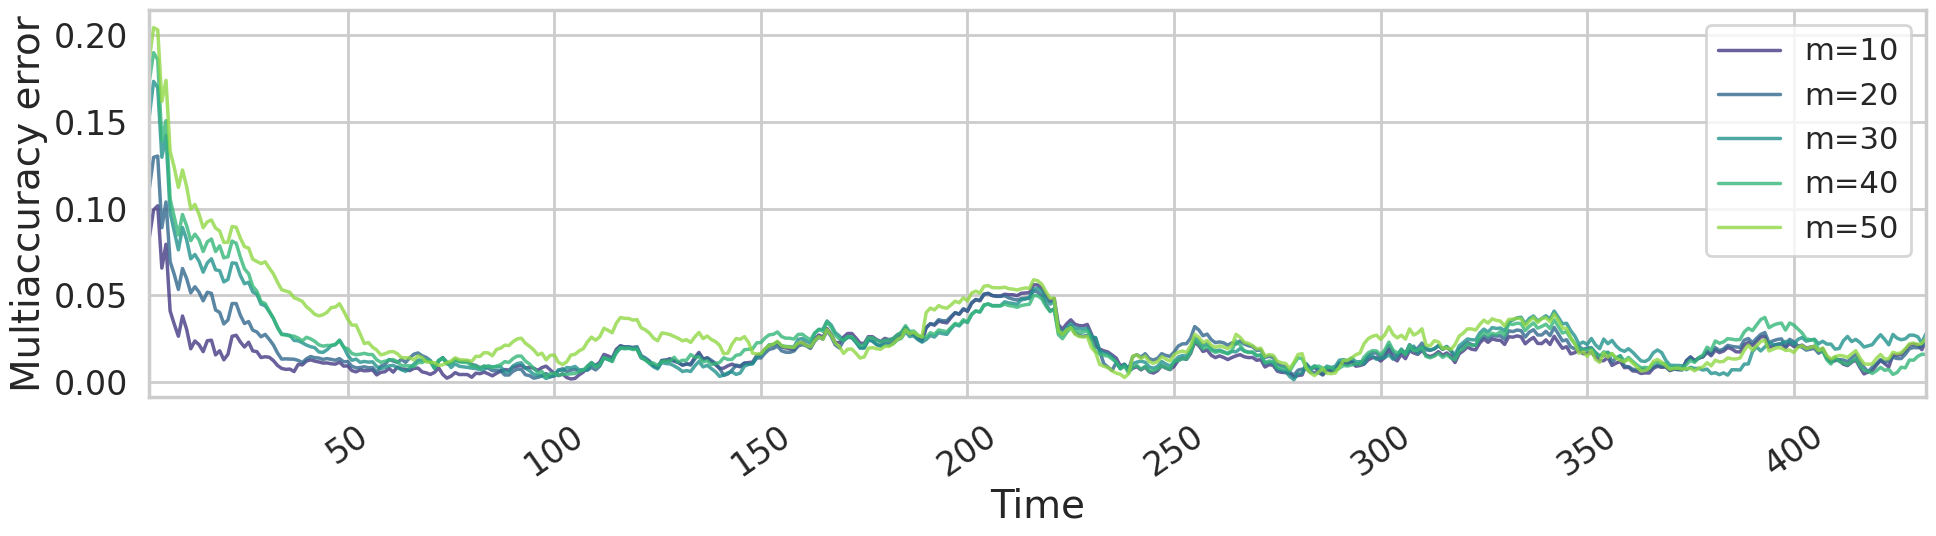

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6), sharex=False)

LEFT_SKIP = 2
T_left = max(len(vals) for vals in mc_rolling_by_n.values())
x_left = np.arange(T_left)[LEFT_SKIP:]

palette = sns.color_palette("viridis", n_colors=len(mc_rolling_by_n))
for color, n in zip(palette, sorted(mc_rolling_by_n.keys())):
    yy = np.asarray(mc_rolling_by_n[n])
    ax.plot(x_left, yy[LEFT_SKIP:], label=f"m={n}",
            color=color, linewidth=2.5, alpha=0.8)

ax.set_xlim(x_left[0], x_left[-1])
ax.set_xlabel("Time"); ax.set_ylabel("Multiaccuracy error")
ax.tick_params(axis="x", rotation=35); ax.grid(True)
ax.legend(loc="upper right", ncol=1, fontsize=22)

plt.tight_layout()
fig.savefig(os.path.join(plots_dir, f"mc_rolling_ma_error_by_n.pdf"), bbox_inches="tight")
plt.show()


In [7]:
num_bins = [2, 3, 4, 5, 6, 7, 8, 9]

mc_ma_losses_by_n = {}
mc_regret_by_n = {}
for n in num_bins:
    print(f"Running MC with num bins={n}")
    mc = OnlineMC(n=n, r=1000, m=num_groups, n_forecaster=10, num_time_steps=T, adaptive=False, seed=42)
    losses_vecs, regrets = [], []
    for date, df_d in tqdm(by_date, total=len(by_date)):
        idxs = df_d['row_id'].to_numpy()
        x_batch = X[idxs]
        y_batch = Y[idxs].astype(float)
        g_batch = G[idxs]
        pt_batch = p_tilde_seq[idxs].astype(float)
        metrics = mc.update(x_batch, y_batch, g_batch, p_tilde=pt_batch)
        losses_vecs.append(np.asarray(metrics["ma_losses"], dtype=float))  # (2m,)
        regrets.append(metrics["l_pred"])
    mc_ma_losses_by_n[n] = losses_vecs
    mc_regret_by_n[n] = regrets

mc_rolling_by_n = {n: rolling_vec_norm(V, window_plot, norm="l_infty") for n, V in mc_ma_losses_by_n.items()}
mc_regret_rolling_by_n = {n: rolling_mean(V, window_plot) for n, V in mc_regret_by_n.items()}

Running MC with num bins=2


100%|██████████| 433/433 [01:27<00:00,  4.97it/s]


Running MC with num bins=3


100%|██████████| 433/433 [01:42<00:00,  4.24it/s]


Running MC with num bins=4


100%|██████████| 433/433 [01:56<00:00,  3.70it/s]


Running MC with num bins=5


100%|██████████| 433/433 [02:14<00:00,  3.22it/s]


Running MC with num bins=6


100%|██████████| 433/433 [02:31<00:00,  2.87it/s]


Running MC with num bins=7


100%|██████████| 433/433 [02:46<00:00,  2.60it/s]


Running MC with num bins=8


100%|██████████| 433/433 [03:05<00:00,  2.33it/s]


Running MC with num bins=9


100%|██████████| 433/433 [03:25<00:00,  2.10it/s]


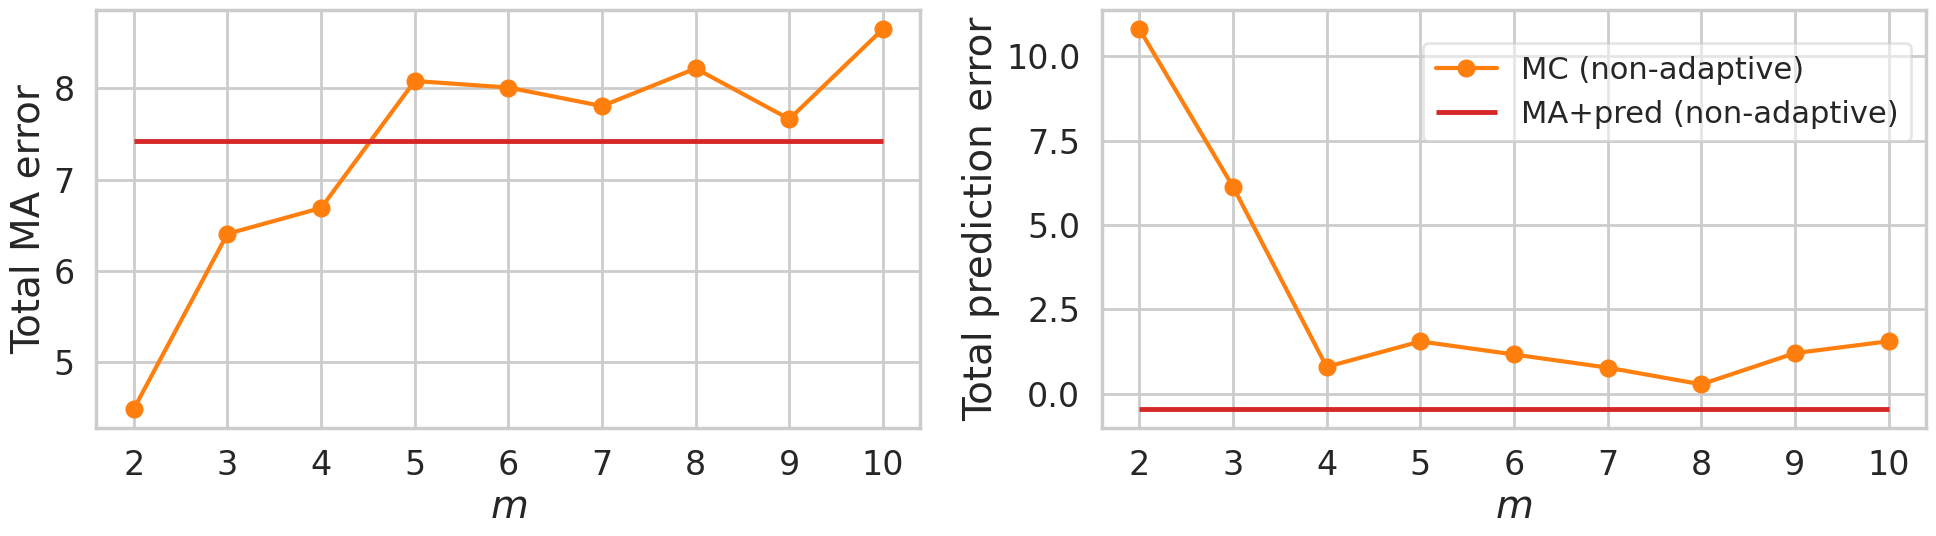

In [12]:
mc_rolling_by_n[10] = mc_nonadaptive_ma_linf
mc_regret_rolling_by_n[10] = mc_nonadaptive_l_pred

LEFT_SKIP = 0  

ms = sorted(mc_rolling_by_n.keys())
tick_ms = [m for m in [2, 3, 4, 5, 6, 7, 8, 9, 10] if m in ms]

# total error per m 
total_ma = [float(np.nansum(np.asarray(mc_rolling_by_n[m])[LEFT_SKIP:])) for m in ms]
total_reg = [float(np.nansum(np.asarray(mc_regret_rolling_by_n[m])[LEFT_SKIP:])) for m in ms]

# constant baseline: total error for mapred_nonadaptive_ma_linf (doesn't vary with m)
total_mapred_na_ma = float(np.nansum(np.asarray(mapred_nonadaptive_ma_linf)[LEFT_SKIP:]))
total_mapred_na_reg = float(np.nansum(np.asarray(mapred_nonadaptive_l_pred)[LEFT_SKIP:]))

fig, axm = plt.subplots(1, 2, figsize=(20, 6))
ax_ma, ax_reg = axm

ax_ma.plot(ms, total_ma, marker="o", linewidth=3, color="tab:orange", label="MC (non-adaptive)")
ax_ma.hlines(total_mapred_na_ma, xmin=min(ms), xmax=max(ms),
          colors="tab:red", linestyles="-", linewidth=3.5,
          label="MA+pred (non-adaptive)")

ax_ma.set_xticks(tick_ms)
ax_ma.set_xlabel(r"$m$")
ax_ma.set_ylabel("Total MA error")
ax_ma.grid(True)

ax_reg.plot(ms, total_reg, marker="o", linewidth=3, color="tab:orange", label="MC (non-adaptive)")
ax_reg.hlines(total_mapred_na_reg, xmin=min(ms), xmax=max(ms),
          colors="tab:red", linestyles="-", linewidth=3.5,
          label="MA+pred (non-adaptive)")

ax_reg.set_xticks(tick_ms)
ax_reg.set_xlabel(r"$m$")
ax_reg.set_ylabel("Total prediction error")
ax_reg.grid(True)

fig.subplots_adjust(right=0.92, wspace=0.28)
handles, labels = [], []
for ax in axm:
    h, l = ax.get_legend_handles_labels()
    handles += h; labels += l
by_label = OrderedDict((l, h) for h, l in zip(handles, labels))
fig.legend(
    by_label.values(), by_label.keys(),
    loc="upper left", bbox_to_anchor=(0.72, 0.9),  # tight to the edge
    ncol=1,
    frameon=True, framealpha=0.5,
    fontsize=22,                
)
plt.tight_layout()
fig.savefig(os.path.join(plots_dir, "mc_total_error_by_m.pdf"), bbox_inches="tight")
plt.show()

### Adaptive MC

In [7]:
from algorithms import OnlineMCAdaptive

In [8]:
mc_adaptive = OnlineMCAdaptive(n=10, r=1000, m=num_groups, eta=eta, num_time_steps=T)

mc_adaptive_ma_losses, mc_adaptive_l_pred = [], []

for date, df_d in tqdm(by_date, total=len(by_date)):
    # Build batch for this date
    idxs = df_d['row_id'].to_numpy()
    x_batch = X[idxs]                                  # (b, d)
    y_batch = Y[idxs].astype(float)                    # (b,)
    g_batch = G[idxs]                                  # (b, m)
    pt_batch = p_tilde_seq[idxs].astype(float)         # (b,)

    metrics = mc_adaptive.update(x_batch, y_batch, g_batch, p_tilde=pt_batch)
    mc_adaptive_ma_losses.append(metrics["ma_losses"])
    mc_adaptive_l_pred.append(metrics["l_pred"])

mc_adaptive_ma_linf = rolling_vec_norm(mc_adaptive_ma_losses, window_plot, norm="l_infty")
mc_adaptive_l_pred = rolling_mean(mc_adaptive_l_pred, window_plot)
  

100%|██████████| 433/433 [14:29<00:00,  2.01s/it]


In [21]:
window_plot_small = int(50 / 2)
window_plot_large = int(50 * 2)

mapred_nonadaptive_ma_linf_small = rolling_vec_norm(mapred_nonadaptive_ma_losses, window_plot_small, norm="l_infty")
mapred_nonadaptive_ma_linf_large = rolling_vec_norm(mapred_nonadaptive_ma_losses, window_plot_large, norm="l_infty")

mapred_ma_linf_small = rolling_vec_norm(mapred_ma_losses, window_plot_small, norm="l_infty")
mapred_ma_linf_large = rolling_vec_norm(mapred_ma_losses, window_plot_large, norm="l_infty")

mc_nonadaptive_ma_linf_small = rolling_vec_norm(mc_nonadaptive_ma_losses, window_plot_small, norm="l_infty")
mc_nonadaptive_ma_linf_large = rolling_vec_norm(mc_nonadaptive_ma_losses, window_plot_large, norm="l_infty")

mc_ma_linf_small = rolling_vec_norm(mc_ma_losses, window_plot_small, norm="l_infty")
mc_ma_linf_large = rolling_vec_norm(mc_ma_losses, window_plot_large, norm="l_infty")

mc_adaptive_ma_linf_small = rolling_vec_norm(mc_adaptive_ma_losses, window_plot_small, norm="l_infty")
mc_adaptive_ma_linf_large = rolling_vec_norm(mc_adaptive_ma_losses, window_plot_large, norm="l_infty")



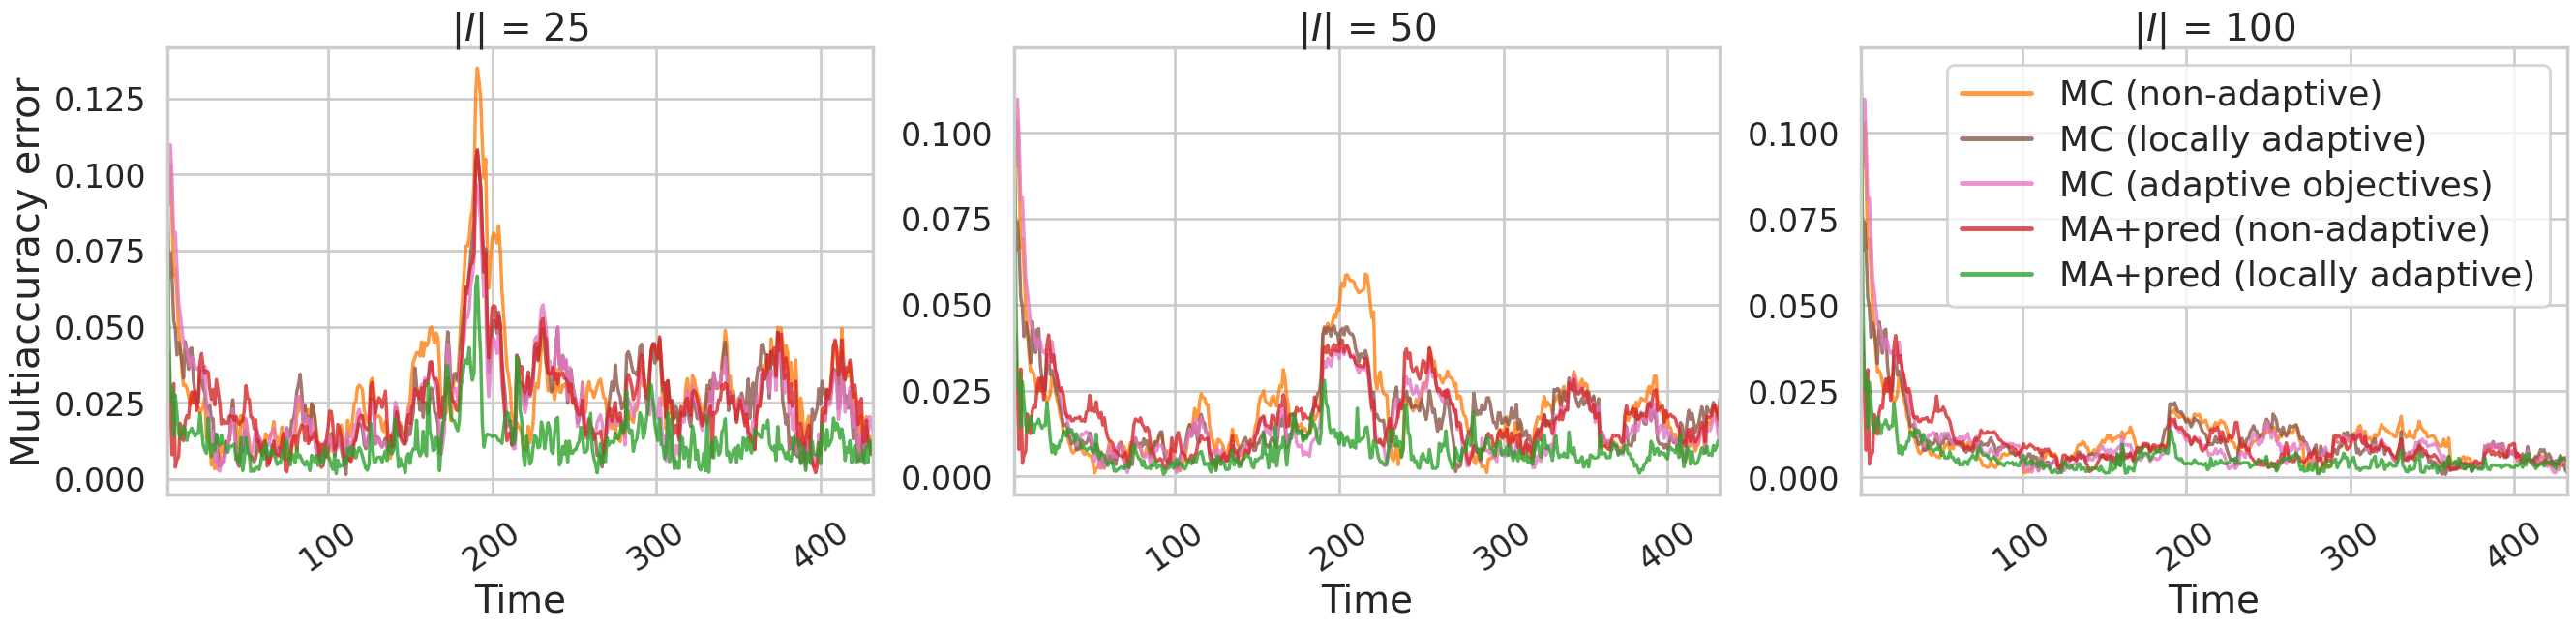

In [25]:
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt

color_dict = {
    'adaptive':                  'tab:green',
    'non-adaptive':              'tab:red',
    'ptilde':                    'tab:blue',
    'ma':                        'tab:purple',
    'mapred_na':                 'tab:red',
    'mapred':                    'tab:green',
    'mc_na':                     'tab:orange',
    'mc_locally_adaptive':       'tab:brown',
    'mc_weakly_adaptive':        'tab:pink',
}


series_to_plot = [
    (mc_nonadaptive_ma_linf,     r"MC (non-adaptive)",           "mc_na"),
    (mc_ma_linf,                 r"MC (locally adaptive)",       "mc_locally_adaptive"),
    (mc_adaptive_ma_linf,        r"MC (adaptive objectives)",    "mc_weakly_adaptive"),
    (mapred_nonadaptive_ma_linf, r"MA+pred (non-adaptive)",      "mapred_na"),
    (mapred_ma_linf,             r"MA+pred (locally adaptive)",  "mapred"),
]

small_series_to_plot = [
    (mc_nonadaptive_ma_linf_small,     r"MC (non-adaptive)",           "mc_na"),
    (mc_ma_linf_small,                 r"MC (locally adaptive)",       "mc_locally_adaptive"),
    (mc_adaptive_ma_linf_small,        r"MC (adaptive objectives)",    "mc_weakly_adaptive"),
    (mapred_nonadaptive_ma_linf_small, r"MA+pred (non-adaptive)",      "mapred_na"),
    (mapred_ma_linf_small,             r"MA+pred (locally adaptive)",  "mapred"),
]

large_series_to_plot = [
    (mc_nonadaptive_ma_linf_large,     r"MC (non-adaptive)",           "mc_na"),
    (mc_ma_linf_large,                 r"MC (locally adaptive)",       "mc_locally_adaptive"),
    (mc_adaptive_ma_linf_large,        r"MC (adaptive objectives)",    "mc_weakly_adaptive"),
    (mapred_nonadaptive_ma_linf_large, r"MA+pred (non-adaptive)",      "mapred_na"),
    (mapred_ma_linf_large,             r"MA+pred (locally adaptive)",  "mapred"),
]

fig, axes = plt.subplots(1, 3, figsize=(32, 6), sharex=False)
ax_small, ax_mid, ax_large = axes

LEFT_SKIP = 2
T_left = max(len(y) for y, _, _ in series_to_plot if y is not None)
x_left = np.arange(T_left)[LEFT_SKIP:]

# LEFT: |I| = 25 
for y, label, group in small_series_to_plot:
    if y is None:
        continue
    yy = np.asarray(y)
    ax_small.plot(x_left, yy[LEFT_SKIP:], label=label,
                  color=color_dict.get(group, "0.3"),
                  linewidth=2.5, alpha=0.8)
ax_small.set_xlim(x_left[0], x_left[-1])
ax_small.set_title(r"$|I|$ = 25")
ax_small.set_xlabel("Time")
ax_small.set_ylabel("Multiaccuracy error", fontsize=30)
ax_small.tick_params(axis="x", rotation=35)
ax_small.grid(True)

# MIDDLE: |I| = 50 
for y, label, group in series_to_plot:
    if y is None:
        continue
    yy = np.asarray(y)
    ax_mid.plot(x_left, yy[LEFT_SKIP:], label=label,
                color=color_dict.get(group, "0.3"),
                linewidth=2.5, alpha=0.8)
ax_mid.set_xlim(x_left[0], x_left[-1])
ax_mid.set_title(r"$|I|$ = 50")
ax_mid.set_xlabel("Time")
ax_mid.tick_params(axis="x", rotation=35)
ax_mid.grid(True)

# RIGHT: |I| = 100 
for y, label, group in large_series_to_plot:
    if y is None:
        continue
    yy = np.asarray(y)
    ax_large.plot(x_left, yy[LEFT_SKIP:], label=label,
                  color=color_dict.get(group, "0.3"),
                  linewidth=2.5, alpha=0.8)
ax_large.set_xlim(x_left[0], x_left[-1])
ax_large.set_title(r"$|I|$ = 100")
ax_large.set_xlabel("Time")
ax_large.tick_params(axis="x", rotation=35)
ax_large.grid(True)

leg = ax_large.legend(loc="upper right", bbox_to_anchor=(1, 1), ncol=1, fontsize=26, labelspacing=0.35)

for line in leg.get_lines():
    line.set_linewidth(3.5)

plt.savefig(os.path.join(plots_dir, "adaptive_mc_comparison.pdf"), dpi=300, bbox_inches="tight")
plt.show()

### Adaptive MA+pred

In [26]:
window_plot_small = int(50 / 2)
window_plot_large = int(50 * 2)

mapred_nonadaptive_ma_linf_small = rolling_vec_norm(mapred_nonadaptive_ma_losses, window_plot_small, norm="l_infty")
mapred_nonadaptive_ma_linf_large = rolling_vec_norm(mapred_nonadaptive_ma_losses, window_plot_large, norm="l_infty")

mapred_ma_linf_small = rolling_vec_norm(mapred_ma_losses, window_plot_small, norm="l_infty")
mapred_ma_linf_large = rolling_vec_norm(mapred_ma_losses, window_plot_large, norm="l_infty")

mapred_adaptive_efficient_ma_linf_small = rolling_vec_norm(mapred_adaptive_efficient_ma_losses, window_plot_small, norm="l_infty")
mapred_adaptive_efficient_ma_linf_large = rolling_vec_norm(mapred_adaptive_efficient_ma_losses, window_plot_large, norm="l_infty")


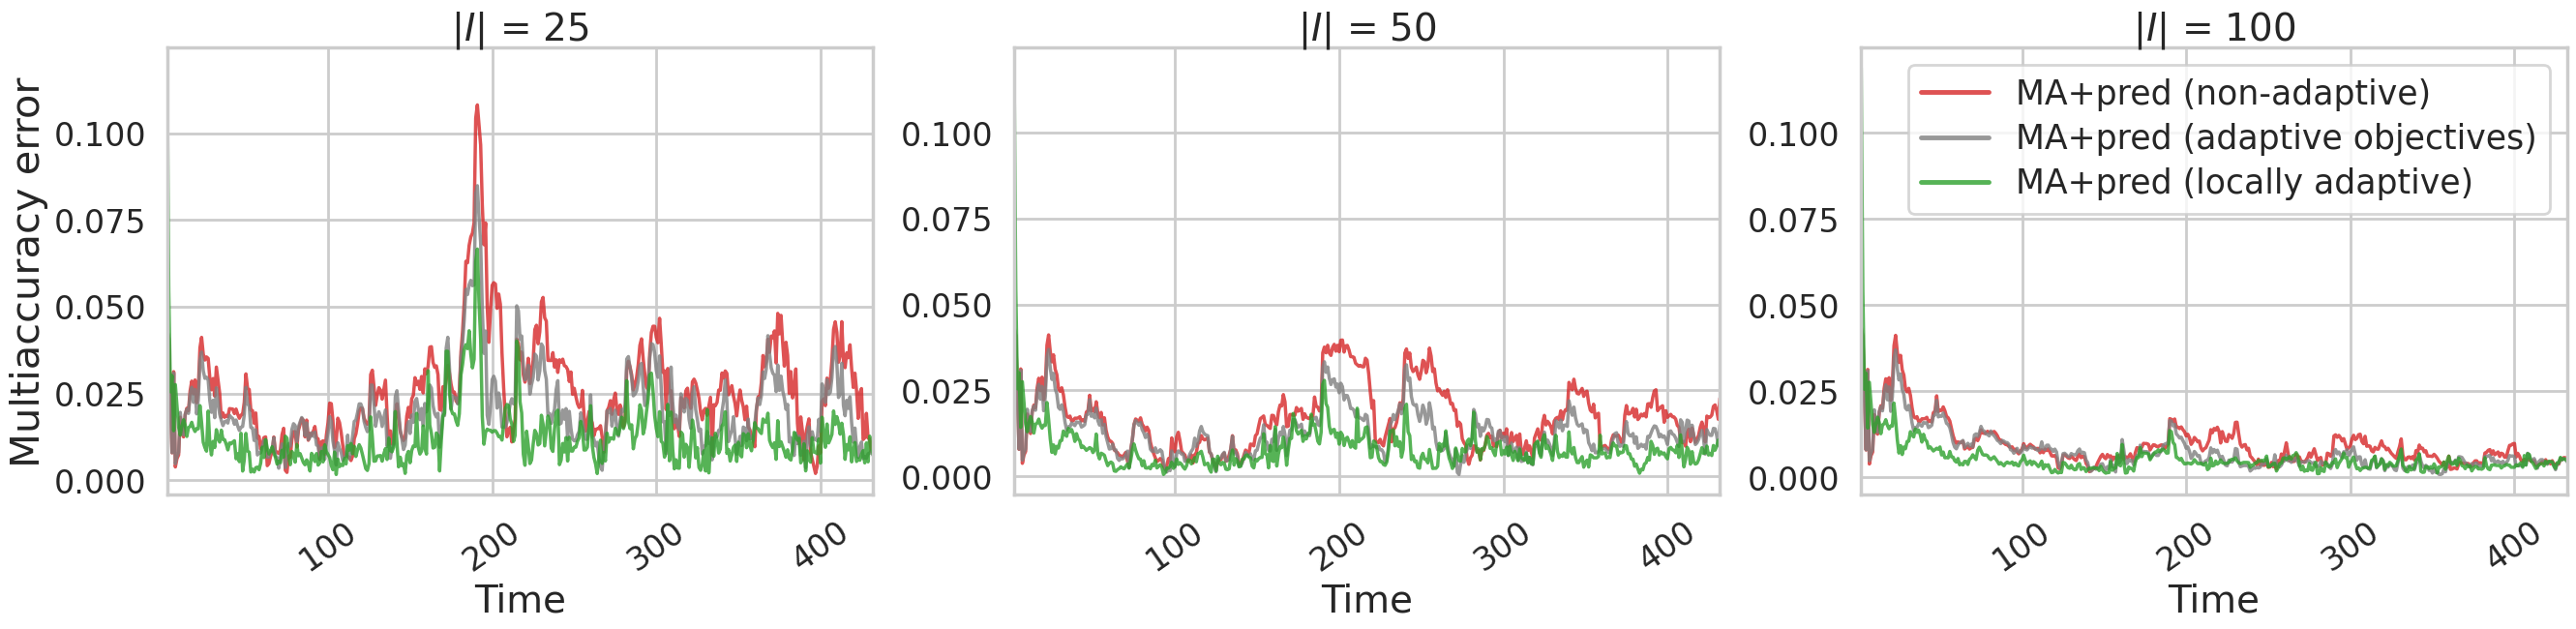

In [ ]:
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt

color_dict = {
    'adaptive':                  'tab:green',
    'non-adaptive':              'tab:red',
    'ptilde':                    'tab:blue',
    'ma':                        'tab:purple',
    'mapred_na':                 'tab:red',
    'mapred':                    'tab:green',
    'mc_na':                     'tab:orange',
    'mc_locally_adaptive':       'tab:brown',
    'mc_weakly_adaptive':        'tab:pink',
    'mapred_weakly_adaptive':    'tab:gray',
}


series_to_plot = [
    (mapred_nonadaptive_ma_linf,        r"MA+pred (non-adaptive)",        "mapred_na"),
    (mapred_adaptive_efficient_ma_linf, r"MA+pred (adaptive objectives)", "mapred_weakly_adaptive"),
    (mapred_ma_linf,                    r"MA+pred (locally adaptive)",    "mapred"),
]

small_series_to_plot = [
    (mapred_nonadaptive_ma_linf_small,          r"MA+pred (non-adaptive)",        "mapred_na"),
    (mapred_adaptive_efficient_ma_linf_small,   r"MA+pred (adaptive objectives)", "mapred_weakly_adaptive"),
    (mapred_ma_linf_small,                      r"MA+pred (locally adaptive)",    "mapred"),
]

large_series_to_plot = [
    (mapred_nonadaptive_ma_linf_large,          r"MA+pred (non-adaptive)",        "mapred_na"),
    (mapred_adaptive_efficient_ma_linf_large,   r"MA+pred (adaptive objectives)", "mapred_weakly_adaptive"),
    (mapred_ma_linf_large,                      r"MA+pred (locally adaptive)",    "mapred"),
]

fig, axes = plt.subplots(1, 3, figsize=(32, 6), sharex=False)
ax_small, ax_mid, ax_large = axes

LEFT_SKIP = 2
T_left = max(len(y) for y, _, _ in series_to_plot if y is not None)
x_left = np.arange(T_left)[LEFT_SKIP:]

# LEFT: |I| = 25 
for y, label, group in small_series_to_plot:
    if y is None:
        continue
    yy = np.asarray(y)
    ax_small.plot(x_left, yy[LEFT_SKIP:], label=label,
                  color=color_dict.get(group, "0.3"),
                  linewidth=2.5, alpha=0.8)
ax_small.set_xlim(x_left[0], x_left[-1])
ax_small.set_title(r"$|I|$ = 25")
ax_small.set_xlabel("Time")
ax_small.set_ylabel("Multiaccuracy error", fontsize=30)
ax_small.tick_params(axis="x", rotation=35)
ax_small.grid(True)

# MIDDLE: |I| = 50 
for y, label, group in series_to_plot:
    if y is None:
        continue
    yy = np.asarray(y)
    ax_mid.plot(x_left, yy[LEFT_SKIP:], label=label,
                color=color_dict.get(group, "0.3"),
                linewidth=2.5, alpha=0.8)
ax_mid.set_xlim(x_left[0], x_left[-1])
ax_mid.set_title(r"$|I|$ = 50")
ax_mid.set_xlabel("Time")
ax_mid.tick_params(axis="x", rotation=35)
ax_mid.grid(True)

# RIGHT: |I| = 100 
for y, label, group in large_series_to_plot:
    if y is None:
        continue
    yy = np.asarray(y)
    ax_large.plot(x_left, yy[LEFT_SKIP:], label=label,
                  color=color_dict.get(group, "0.3"),
                  linewidth=2.5, alpha=0.8)
ax_large.set_xlim(x_left[0], x_left[-1])
ax_large.set_title(r"$|I|$ = 100")
ax_large.set_xlabel("Time")
ax_large.tick_params(axis="x", rotation=35)
ax_large.grid(True)

leg = ax_large.legend(loc="upper right", bbox_to_anchor=(1, 1), ncol=1, fontsize=25, labelspacing=0.35)
for line in leg.get_lines():
    line.set_linewidth(3.5)

plt.savefig(os.path.join(plots_dir, "adaptive_mapred_comparison.pdf"), dpi=300, bbox_inches="tight")
plt.show()

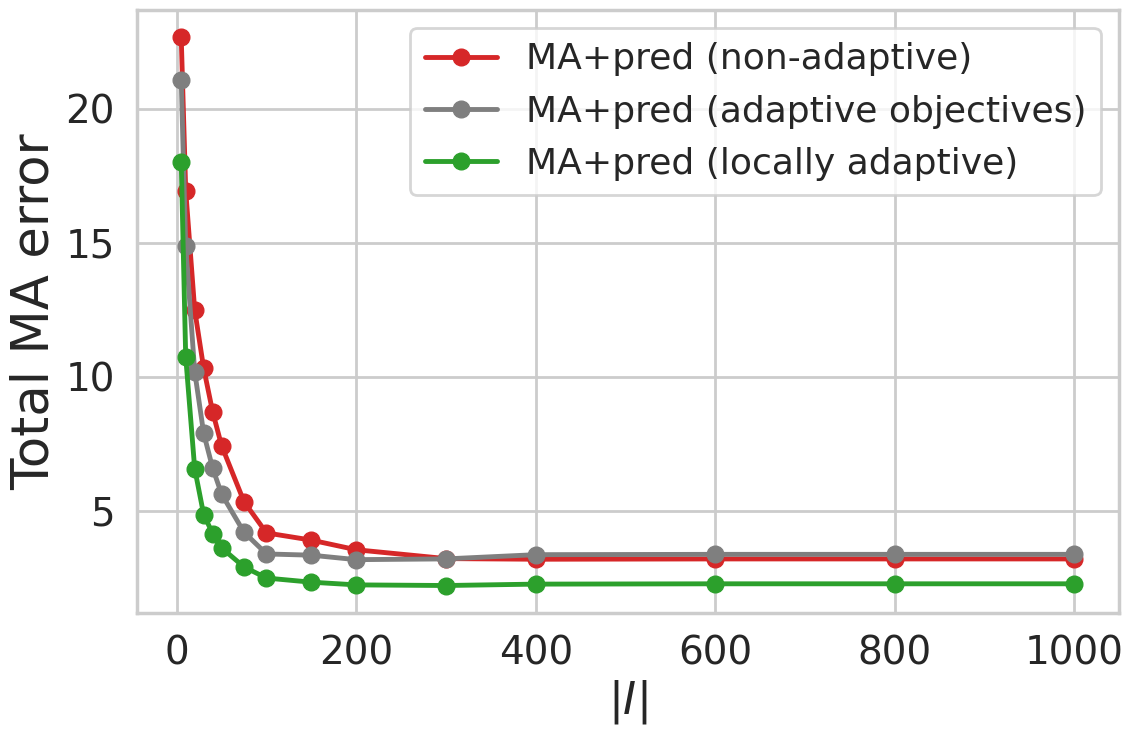

In [29]:
window_grid = [5, 10, 20, 30, 40, 50, 75, 100, 150, 200, 300, 400, 600, 800, 1000]
LEFT_SKIP = 0  

methods = {
    "MA+pred (non-adaptive)":        (mapred_nonadaptive_ma_losses,         "tab:red", "-"),
    "MA+pred (adaptive objectives)": (mapred_adaptive_efficient_ma_losses,  "tab:gray", "-"),
    "MA+pred (locally adaptive)":    (mapred_ma_losses,                     "tab:green", "-"),
}

totals_by_method = {name: [] for name in methods.keys()}

for w in window_grid:
    for name, (losses_vecs, _, _) in methods.items():
        # rolling over vectors then norm; use same function as elsewhere
        series = rolling_vec_norm(losses_vecs, w, norm="l_infty")
        totals_by_method[name].append(float(np.nansum(np.asarray(series)[LEFT_SKIP:])))

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
for name, (losses_vecs, color, ls) in methods.items():
    ax.plot(window_grid, totals_by_method[name], marker="o", color=color, linestyle=ls, linewidth=3.5, label=name)

ax.set_xlabel(r"$|I|$", fontsize=32)
ax.set_ylabel("Total MA error", fontsize=37)
ax.tick_params(axis="x", labelsize=28)
ax.tick_params(axis="y", labelsize=28)
ax.grid(True)
ax.legend(loc="best", fontsize=26)
plt.tight_layout()

fig.savefig(os.path.join(plots_dir, "total_ma_error_adaptive_mapred_comparison.pdf"), bbox_inches="tight")
plt.show()

### Varying $|I|$

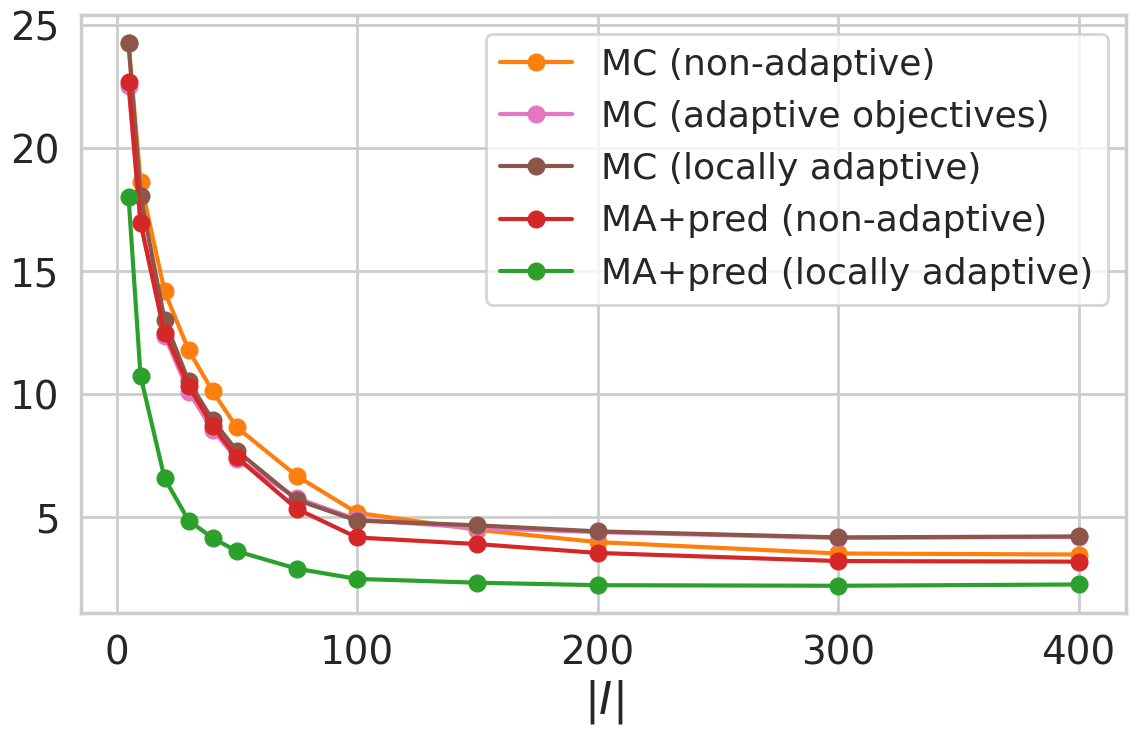

In [30]:
window_grid = [5, 10, 20, 30, 40, 50, 75, 100, 150, 200, 300, 400]
LEFT_SKIP = 0  

methods = {
    "MC (non-adaptive)":            (mc_nonadaptive_ma_losses,     "tab:orange",  "-"),
    "MC (adaptive objectives)":     (mc_adaptive_ma_losses,        "tab:pink","-"),
    "MC (locally adaptive)":        (mc_ma_losses,                 "tab:brown", "-"),
    "MA+pred (non-adaptive)":       (mapred_nonadaptive_ma_losses, "tab:red", "-"),
    "MA+pred (locally adaptive)":   (mapred_ma_losses,             "tab:green", "-"),
}

totals_by_method = {name: [] for name in methods.keys()}

for w in window_grid:
    for name, (losses_vecs, _, _) in methods.items():
        series = rolling_vec_norm(losses_vecs, w, norm="l_infty")
        totals_by_method[name].append(float(np.nansum(np.asarray(series)[LEFT_SKIP:])))

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
for name, (losses_vecs, color, ls) in methods.items():
    ax.plot(window_grid, totals_by_method[name], marker="o", color=color, linestyle=ls, linewidth=3, label=name)

ax.set_xlabel(r"$|I|$", fontsize=32)
ax.tick_params(axis="x", labelsize=28)
ax.tick_params(axis="y", labelsize=28)
ax.grid(True)
ax.legend(loc="best", fontsize=26)
plt.tight_layout()

fig.savefig(os.path.join(plots_dir, "total_ma_error_vs_window_all_methods.pdf"), bbox_inches="tight")
plt.show()